# Latent Space Exploration and Manipulation with VAE

In [1]:
import sys 
import os 

sys.path.append(os.path.abspath(".."))

In [2]:
import torch 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import os
import PIL
from PIL import Image
import numpy as np 
import matplotlib.pyplot as plt 
import torchvision 
from src.model import VAE
from src.train import train, loss

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
df = pd.read_csv(r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data\celeba\list_attr_celeba.csv", sep=",", encoding="utf-8") 
df

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Ángel\\Documents\\GitHub\\vae-project\\notebooks\\data\\celeba\\list_attr_celeba.csv'

In [4]:
root = r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data\celeba\img_align_celeba"
img_list = os.listdir(root)
print(len(img_list))

202600


Cargando manualmente CelebA

In [4]:
class CeleADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = os.listdir(root_dir)
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(".jpg")]  

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        
        
        # We open the image using PIL y la convertimos a RGB
        try:
            image = Image.open(img_name).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
            return None

        
        if self.transform:
            image = self.transform(image)

        image = image.view(-1)  # Aplanamos la imagen aquí

        return image

In [5]:
def load_celeba(root_dir, batch_size = 64, image_size = 64, num_workers = 4):
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        # Normalizamos a [-1, 1]
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])

    dataset = CeleADataset(root_dir= root_dir, transform=transform)

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers= num_workers,
        pin_memory=True,
        drop_last=True
    )

    return dataloader

In [6]:
celeba_root = r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data\celeba\img_align_celeba"

celeba_loader = load_celeba(celeba_root, num_workers=0, image_size=64)

In [14]:
for batch in celeba_loader:
    print(f"{batch.shape}")
    break

torch.Size([64, 3, 128, 128])


In [15]:
def denormalize(tensor):

    if len(tensor.shape) == 4:
        result = tensor.clone().detach()
        result = (result * 0.5 ) + 0.5
        return result
    else:
        # Single image
        return (tensor * 0.5) + 0.5

In [42]:
def visualize_celeba_examples(dataloader, num_examples, fig_size = (15,15)):
    dataiter = iter(dataloader)
    images = next(dataiter)

    images = images[:num_examples]

    images = denormalize(images)

    nrow = int(np.sqrt(num_examples))

    grid = torchvision.utils.make_grid(images, nrow=nrow, padding=2)

    grid_np = grid.cpu().numpy().transpose((1,2,0))

    plt.figure(figsize=fig_size)
    plt.imshow(grid_np)
    plt.axis('off')
    plt.title('Ejemplos del Dataset CelebA')
    plt.show()

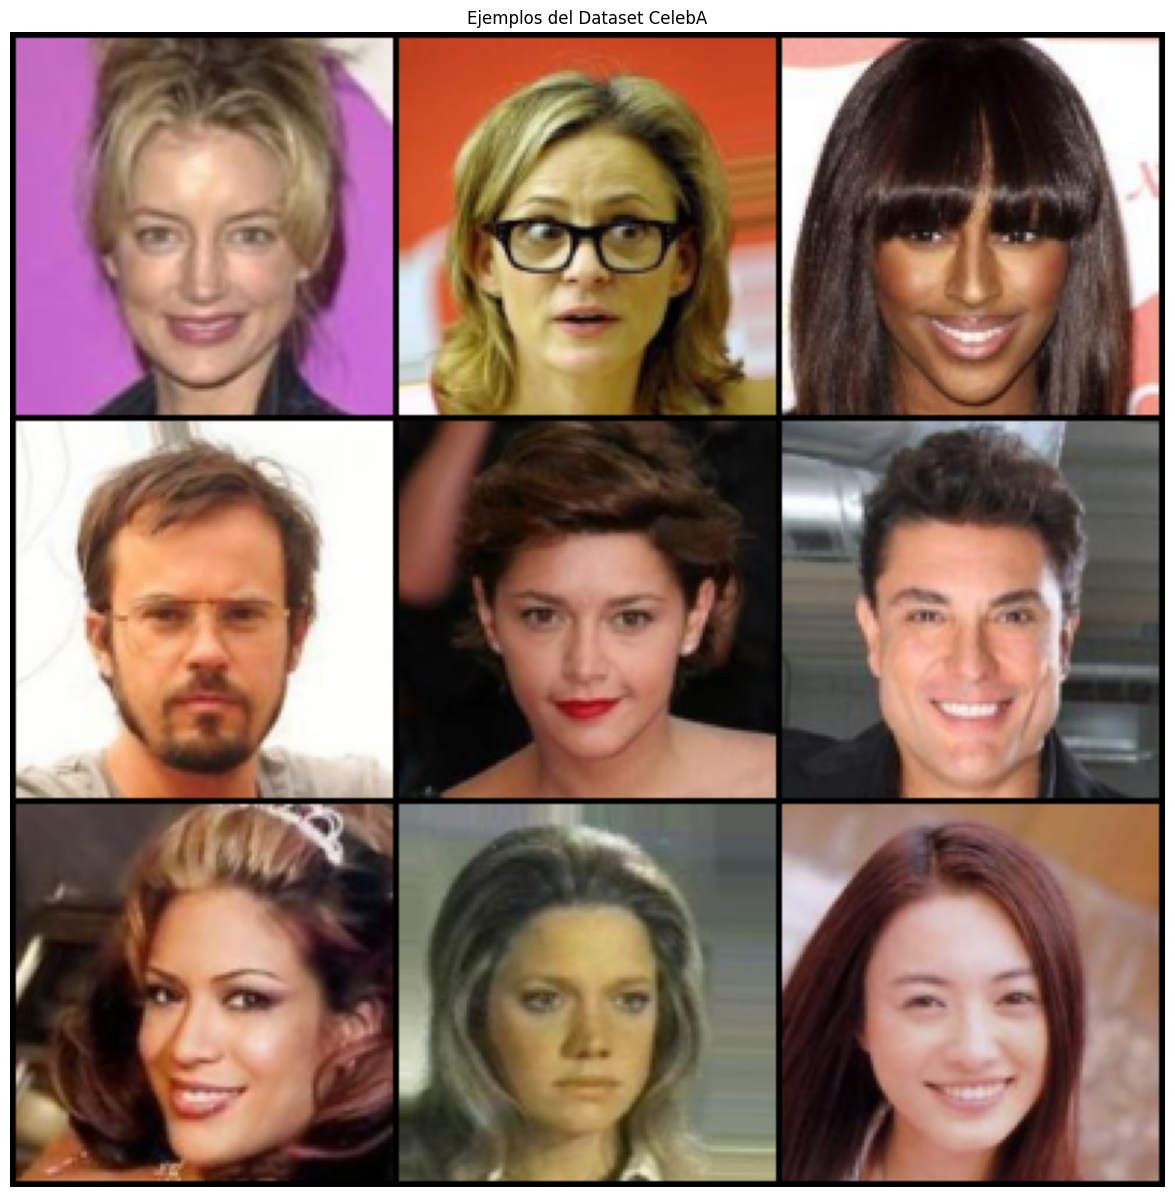

In [17]:
visualize_celeba_examples(dataloader=celeba_loader, num_examples=9, fig_size=(15,15))

In [7]:
hidden_dims = [512, 256]
latent_dim = 64
input_dim = 3 * 64 * 64

vae_model = VAE(input_dim, hidden_dims, latent_dim)
optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for batch in celeba_loader:
    print(batch.shape)
    break

# Entrenamos
train(vae_model, celeba_loader, optimizer, device, epochs=20)

torch.Size([64, 12288])


KeyboardInterrupt: 